# Training

In [ ]:
# run the following command in the terminal to open Tensorboard
# tensorboard --logdir=sarl/runs --reload_multifile True --port=6007


In [ ]:
from envs.sagin_v1 import *
from envs.utils import *
from stable_baselines3 import PPO
import torch
from stable_baselines3.common.env_checker import check_env
import datetime


n_steps = 128 * 10_000

env = SingleDroneEnv(
    max_cycles=128,
)
env.reset(seed=42)

check_env(env)

model = PPO(
    policy = "MlpPolicy",
    env = env,
    # learning_rate = 1e-3,   # default: 3e-4
    # n_steps = 512, # no of steps to run for each environment per update
    # batch_size = 32,
    # ent_coef = 0.1,
    # vf_coef = 0.1,
    tensorboard_log = "sarl/runs",
    # policy_kwargs = {
    #     "activation_fn": torch.nn.ReLU,
    #     "net_arch": dict(vf=[1024, 512], pi=[1024, 512]),  # "net_arch": [1024, 512,],
    # },
    device = "cuda",
    # verbose=1,
)

model.learn(
    total_timesteps=n_steps,
    progress_bar=True
)

# model.save(f"sarl/trained_agents/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/ppo")
model.save(f"sarl/trained_agents/ppo_{n_steps/1e3:.0f}k")


# Testing

In [2]:
from envs.sagin_v1 import *
from envs.utils import *
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env


env = SingleDroneEnv(
        max_cycles=256,
        seed=None,
        uav_init_mode='specific',
        uav_init_locs=np.array([1000, 1000]).reshape(2, -1)
)
check_env(env)

model = PPO.load("sarl/trained_agents/stable/ppo_2560k_max_drate")

Terminated with 111/256 steps
UAV's final position: [0.68784392 0.55027514]
Image saved to /mnt/newdiskpartition/uavbs-placement-marl/code/sarl/images/observation.png


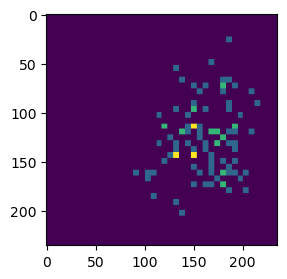

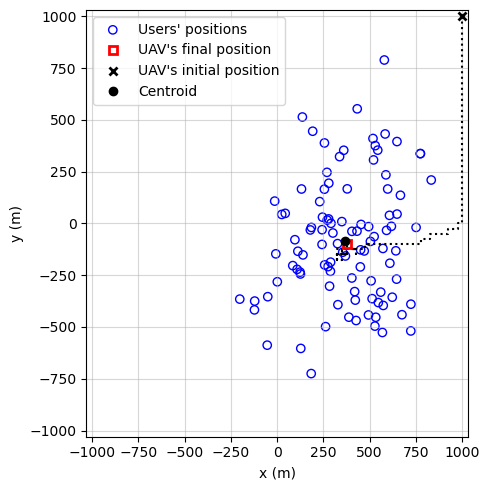

In [11]:
""" RUN AN EPISODE """
observation, info = env.reset(seed=42)
log_uav_locs = env.locs['self']
while True:
        # action = env.action_space.sample()  # agent policy that uses the observation and info
        action, _states = model.predict(observation)        # deterministic=True
        observation, reward, terminated, truncated, info = env.step(action.item())
        log_uav_locs = np.append(log_uav_locs, env.locs['self'], axis=1)

        if terminated or truncated:
                break

print(f"Terminated with {1 + env.n_steps}/{env.max_cycles} steps")
# env.close()

""" PLOTTING: OBSERVATIONS OF THE AGENT """
ob_last = observation.copy()
print(f"UAV's final position: {ob_last[:2]}")
hm = ob_last[2:].reshape(40, -1)
save_img_from_rgba_arr(hm, transparent=False, fpath="sarl/images/observation.png")

fig, ax = plt.subplots(figsize=(3,3))
im = plt.imread("sarl/images/observation.png")
ax.imshow(im)
plt.show()


""" PLOTTING: TRAJECTORY """
log_uav_locs = np.array(log_uav_locs)
x_drone = log_uav_locs[0]
y_drone = log_uav_locs[1]
x_users = env.locs['user'][0]
y_users = env.locs['user'][1]
bound = env.bound

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(x_users, y_users, marker='o', facecolors='none', edgecolors='b')
ax.scatter(x_users[-1], y_users[-1], marker='o', facecolors='none', 
           edgecolors='b', label="Users' positions"
)
ax.plot(x_drone, y_drone, ":", color="k")
ax.plot(x_drone[-1], y_drone[-1], marker='s', markerfacecolor='none',
        markeredgecolor = 'r', markeredgewidth=2, linestyle='none',
        label="UAV's final position"
)
ax.plot(x_drone[0], y_drone[0], marker='x', color='k', markeredgewidth=2,
        linestyle='none', label="UAV's initial position"
)
ax.plot(np.mean(x_users), np.mean(y_users), 'ok', label="Centroid")

plt.xlim(-bound - 30, bound + 30)
plt.ylim(-bound - 30, bound + 30)
plt.grid(True, alpha=0.5)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend()
plt.tight_layout()

plt.savefig(fname='sarl/images/trajectory.png')
plt.show()